### Competition Series 1: Forecast use of a city bike share system

Data come from kaggle https://www.kaggle.com/c/bike-sharing-demand.

https://www.kaggle.com/c/bike-sharing-demand/leaderboard

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

%matplotlib inline
sns.set_context("paper")

:0: FutureWarning: IPython widgets are experimental and may change in the future.


### 1. import the data

In [2]:
train = pd.read_csv('bike_train.csv')
test = pd.read_csv('bike_test.csv')

### 2. add new variables

- When I see the time variable, I will always construct other features such as 'year' 'month' 'day' 'weekday'  'hour'.Here, the variable of 'day' is used to split dataset, so I do not make 'day' in test.

- By observing the biking behavior of casual and registered users, I add two features 'adverse_rush_hour' and 'rush_hour_working'.

- After I checked many messages on the kaggle discussion group, I find out the log value is important to skew distribution, especailly to the variables casual and register and count, our goal variables.

In [3]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['year'] = train['datetime'].map(lambda x: x.year)
train['month'] = train['datetime'].map(lambda x: x.month)
train['hour'] = train['datetime'].map(lambda x: x.hour)
train['day'] = train['datetime'].map(lambda x: x.day)
train['weekday'] = train['datetime'].map(lambda x: x.dayofweek)

test['datetime'] = pd.to_datetime(test['datetime'])
test['year'] = test['datetime'].map(lambda x: x.year)
test['month'] = test['datetime'].map(lambda x: x.month)
test['hour'] = test['datetime'].map(lambda x: x.hour)
test['weekday'] = test['datetime'].map(lambda x: x.dayofweek)

# workingday is already exclude weekend and holiday
train['weekend'] = (train['weekday'] == 5) | (train['weekday'] == 6)
test['weekend'] = (test['weekday'] == 5) | (test['weekday'] == 6)

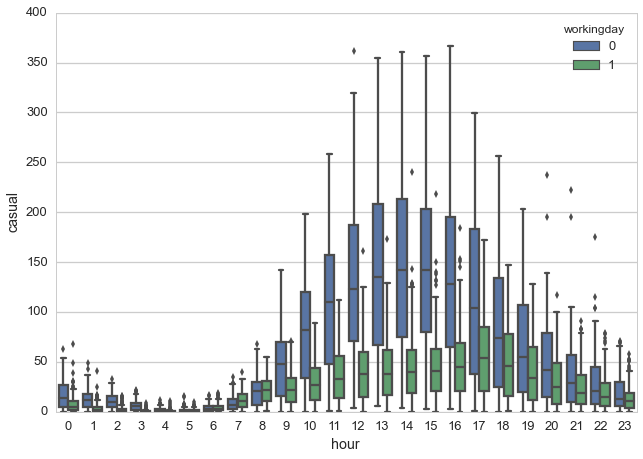

In [6]:
# nonmeber bikers
# just like freelance, no workingday is more active 
sns.boxplot(x = 'hour', y = 'casual', hue = 'workingday', data = train);

In [4]:
# for casual pattern
train['adverse_rush_hour'] = abs(train['hour'] -14)
test['adverse_rush_hour'] = abs(test['hour'] -14)

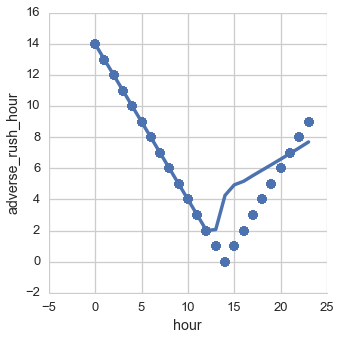

In [8]:
sns.lmplot(x = 'hour', y = 'adverse_rush_hour', data = train, lowess = True, scatter_kws={"s": 80});

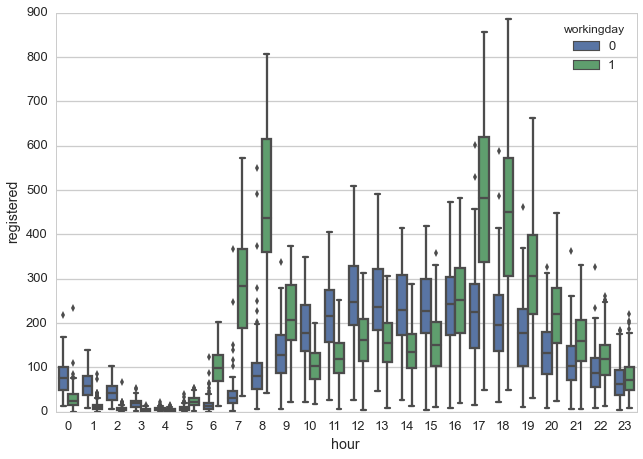

In [9]:
# member bikers
# at workingday, they active at 8 o'clock, 17 o'clock, 18 o'clock rush hour.
# feature rush_hour_working focus on above situation.
####################
# at no workingday, their biking behaviour just like the nonmember biker (casual). 
# feature adverse_rush_hour focus on above situation.
sns.boxplot(x = 'hour', y = 'registered', hue = 'workingday', data = train);

In [5]:
# for registered workingday pattern
train['rush_hour_working'] = ((train['hour'] == 7) | (train['hour'] == 8) | (train['hour'] == 17) |\
                    (train['hour'] == 18) | (train['hour'] == 19)) & (train['workingday'] == 1)

test['rush_hour_working'] = ((test['hour'] == 7) | (test['hour'] == 8) | (test['hour'] == 17) |\
                    (test['hour'] == 18) | (test['hour'] == 19)) & (test['workingday'] == 1)

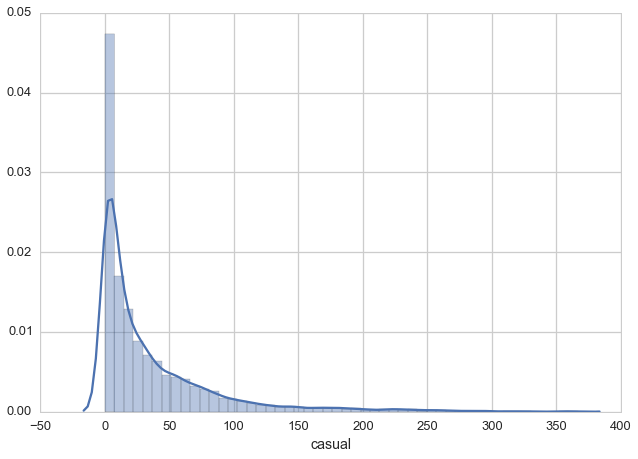

In [27]:
# skew distribution
sns.distplot(train.casual);

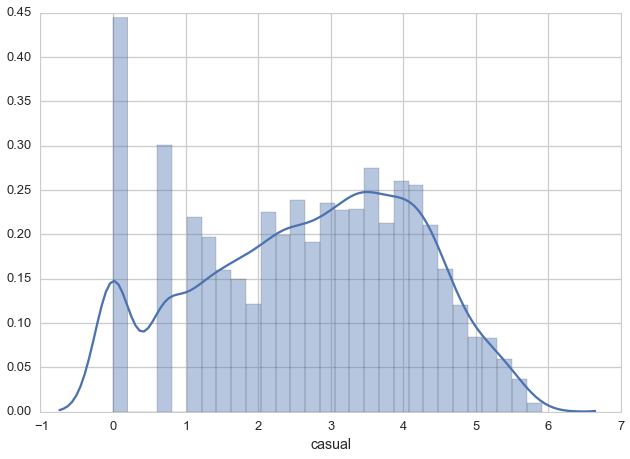

In [28]:
# log
sns.distplot(np.log(train.casual + 1));

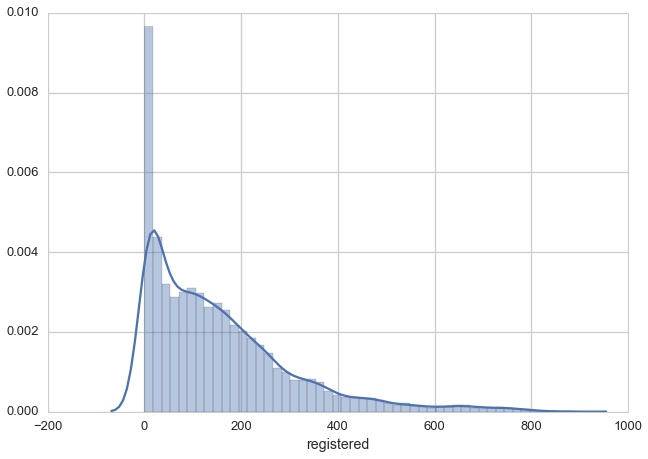

In [34]:
sns.distplot(train.registered);

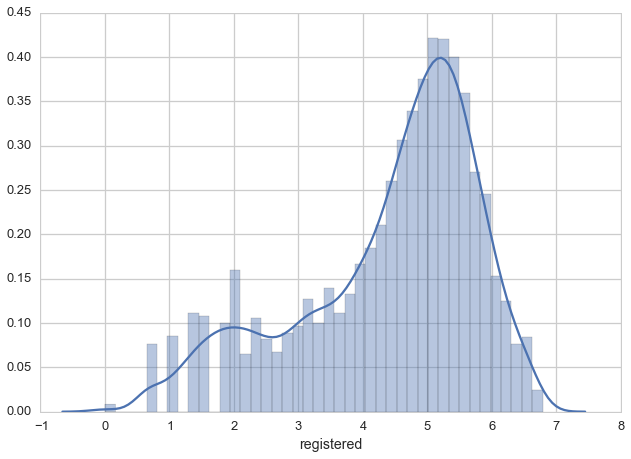

In [33]:
sns.distplot(np.log(train.registered + 1));

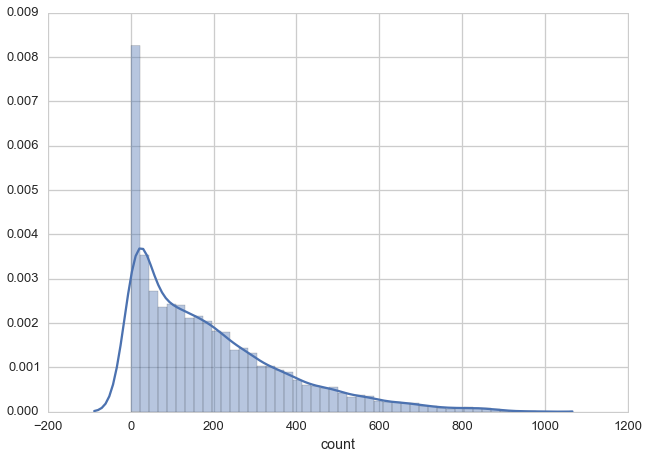

In [36]:
sns.distplot(train['count']);

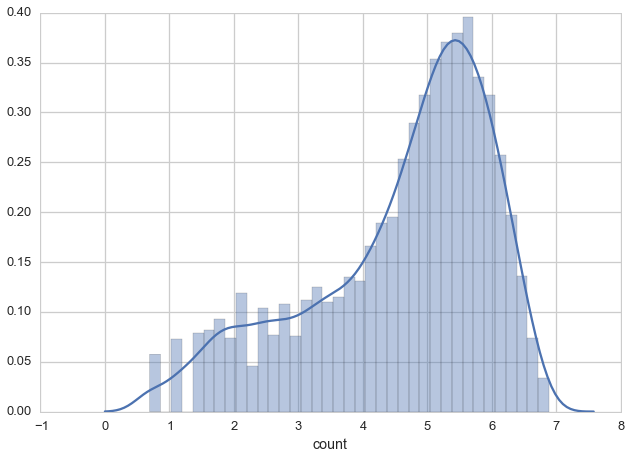

In [37]:
sns.distplot(np.log(train['count'] + 1));

### 3. train the model

In [12]:
from sklearn.cross_validation import cross_val_score

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV, LassoLarsCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, \
AdaBoostRegressor, GradientBoostingRegressor

In [14]:
# model
lr = LinearRegression()
ridge = RidgeCV()
lasso = LassoCV()
net = ElasticNetCV()
lar = LarsCV()
lassolars = LassoLarsCV()

tree = DecisionTreeRegressor(random_state = 0)
knn = KNeighborsRegressor()
svr_l = SVR(kernel = 'linear')
svr_r = SVR()

n_estimators = 100
bag = BaggingRegressor(DecisionTreeRegressor(), n_estimators = n_estimators, random_state = 0)
rf = RandomForestRegressor(n_estimators = n_estimators, random_state = 0)
etree = ExtraTreesRegressor(n_estimators = n_estimators, random_state = 0)
ada = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators = n_estimators, random_state = 0)
gbr = GradientBoostingRegressor(n_estimators = n_estimators, random_state = 0)

#### 3.1 split the train into train and test

In [38]:
# days 1 to 14
train_train = train[train.day < 15]
# days 15 to 19
train_test = train[train.day >= 15] 

#### 3.2 choose the variables
- Here, I drop 'datetime', because it is not the type of numeric, only numeric or string could run smoothly in some algorithms, and the biggest reason is that I have already derive messages from 'datetime' by create variables 'year' 'month' 'weekday' 'weekend' and 'hour'.

In [42]:
train.columns

Index([u'datetime', u'season', u'holiday', u'workingday', u'weather', u'temp', u'atemp', u'humidity', u'windspeed', u'casual', u'registered', u'count', u'year', u'month', u'hour', u'day', u'weekday', u'weekend', u'adverse_rush_hour', u'rush_hour_working'], dtype='object')

In [55]:
x_1 = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', \
       'year', 'month', 'hour', 'weekday', 'weekend', 'adverse_rush_hour', 'rush_hour_working'] 

#### 3.3 the index to compare models by error

In [49]:
def rmsle(pred_count, actual_count):
    return round(np.sqrt(np.mean((np.log(pred_count + 1) - np.log(actual_count + 1)) ** 2)), 5) 

#### 3.4 try all kinds of models

In [58]:
# bagging
pred = np.exp(bag.fit(train_train[x_1], np.log(train_train['casual'] + 1)).predict(train_test[x_1])) +\
        np.exp(bag.fit(train_train[x_1], np.log(train_train['registered'] + 1)).predict(train_test[x_1])) - 2
rmsle(pred, train_test['count']) 

0.32026

In [60]:
# rf
pred = np.exp(rf.fit(train_train[x_1], np.log(train_train['casual'] + 1)).predict(train_test[x_1])) +\
        np.exp(rf.fit(train_train[x_1], np.log(train_train['registered'] + 1)).predict(train_test[x_1])) - 2
rmsle(pred, train_test['count']) 

0.32084

In [62]:
# etree
pred = np.exp(etree.fit(train_train[x_1], np.log(train_train['casual'] + 1)).predict(train_test[x_1])) +\
        np.exp(etree.fit(train_train[x_1], np.log(train_train['registered'] + 1)).predict(train_test[x_1])) - 2
rmsle(pred, train_test['count']) 

0.33772

In [86]:
# gbr
pred = np.exp(gbr.fit(train_train[x_1], np.log(train_train['casual'] + 1)).predict(train_test[x_1])) +\
        np.exp(gbr.fit(train_train[x_1], np.log(train_train['registered'] + 1)).predict(train_test[x_1])) - 2
rmsle(pred, train_test['count']) 

0.31392

In [87]:
# ada
pred = np.exp(ada.fit(train_train[x_1], np.log(train_train['casual'] + 1)).predict(train_test[x_1])) +\
        np.exp(ada.fit(train_train[x_1], np.log(train_train['registered'] + 1)).predict(train_test[x_1])) - 2
rmsle(pred, train_test['count']) 

0.3351

#### 3.5 test models in the test dataset

In [98]:
# bagging
# 0.43139 x_1
etree_s_pred2 = np.exp(bag.fit(train[x_1], np.log(train['casual'] + 1)).predict(test[x_1])) +\
                 np.exp(bag.fit(train[x_1], np.log(train['registered'] + 1)).predict(test[x_1])) - 2
etree_s_df2 = pd.DataFrame({'datetime': test.datetime, 'count':pd.Series(etree_s_pred2)}) 
etree_s_df2.to_csv('python_bag_x_1.csv', index = False, date_format = "%Y-%m-%d %H:%M:%S")

In [97]:
# random forest
# predict registered and casual separately
# 0.43000 x_1
etree_s_pred2 = np.exp(rf.fit(train[x_1], np.log(train['casual'] + 1)).predict(test[x_1])) +\
                 np.exp(rf.fit(train[x_1], np.log(train['registered'] + 1)).predict(test[x_1])) - 2
etree_s_df2 = pd.DataFrame({'datetime': test.datetime, 'count':pd.Series(etree_s_pred2)}) 
etree_s_df2.to_csv('python_rf_x_1.csv', index = False, date_format = "%Y-%m-%d %H:%M:%S")

In [96]:
# Extra Tree
# predict registered and casual separately
# 0.41339 x_1
etree_s_pred2 = np.exp(etree.fit(train[x_1], np.log(train['casual'] + 1)).predict(test[x_1])) +\
                 np.exp(etree.fit(train[x_1], np.log(train['registered'] + 1)).predict(test[x_1])) - 2
etree_s_df2 = pd.DataFrame({'datetime': test.datetime, 'count':pd.Series(etree_s_pred2)}) 
etree_s_df2.to_csv('python_etree_x_1.csv', index = False, date_format = "%Y-%m-%d %H:%M:%S")

In [99]:
# gbr
# 0.42185 x_1
etree_s_pred2 = np.exp(gbr.fit(train[x_1], np.log(train['casual'] + 1)).predict(test[x_1])) +\
                 np.exp(gbr.fit(train[x_1], np.log(train['registered'] + 1)).predict(test[x_1])) - 2
etree_s_df2 = pd.DataFrame({'datetime': test.datetime, 'count':pd.Series(etree_s_pred2)}) 
etree_s_df2.to_csv('python_gbr_x_1.csv', index = False, date_format = "%Y-%m-%d %H:%M:%S")

In [100]:
# ada
# 0.41982 x_1
etree_s_pred2 = np.exp(ada.fit(train[x_1], np.log(train['casual'] + 1)).predict(test[x_1])) +\
                 np.exp(ada.fit(train[x_1], np.log(train['registered'] + 1)).predict(test[x_1])) - 2
etree_s_df2 = pd.DataFrame({'datetime': test.datetime, 'count':pd.Series(etree_s_pred2)}) 
etree_s_df2.to_csv('python_ada_x_1.csv', index = False, date_format = "%Y-%m-%d %H:%M:%S")

#### 3.6 the importance of variables in models

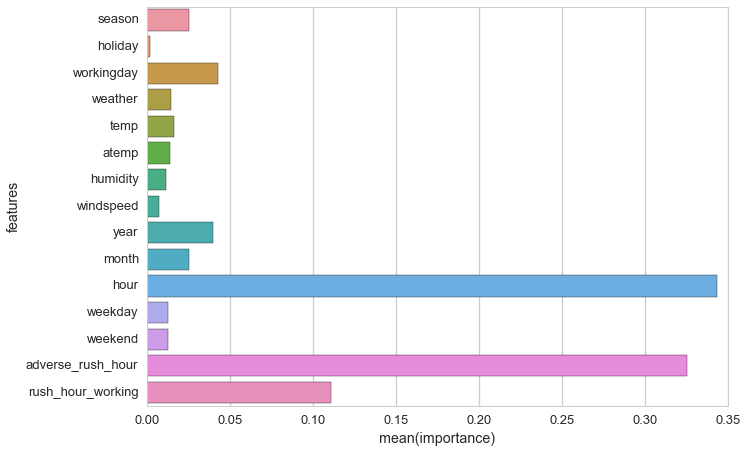

In [102]:
imp = etree.fit(train[x_1], np.log(train['registered'] + 1)).feature_importances_
df_imp = pd.DataFrame({'features':x_1, 'importance': imp})
sns.barplot(y = 'features', x = 'importance', data = df_imp);

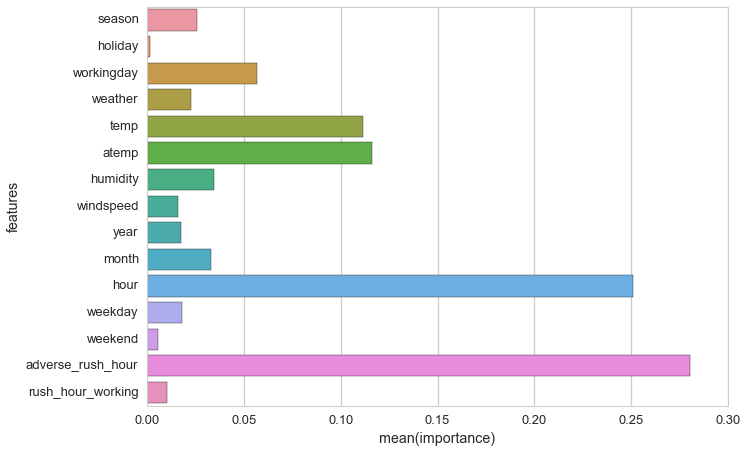

In [103]:
imp = etree.fit(train[x_1], np.log(train['casual'] + 1)).feature_importances_
df_imp = pd.DataFrame({'features':x_1, 'importance': imp})
sns.barplot(y = 'features', x = 'importance', data = df_imp);

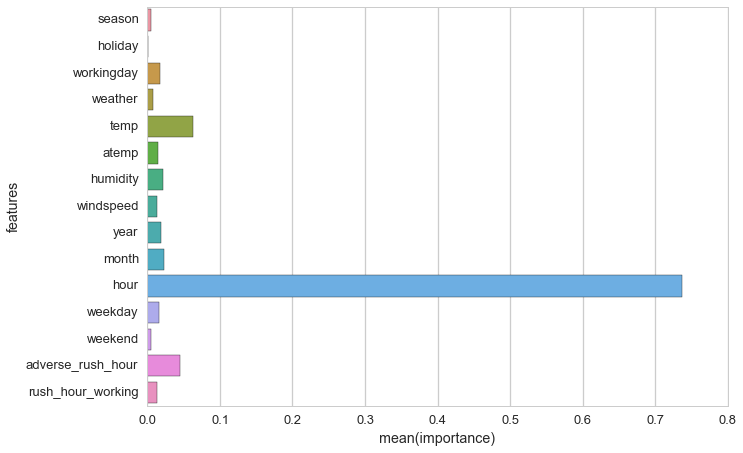

In [104]:
imp = ada.fit(train[x_1], np.log(train['registered'] + 1)).feature_importances_
df_imp = pd.DataFrame({'features':x_1, 'importance': imp})
sns.barplot(y = 'features', x = 'importance', data = df_imp);

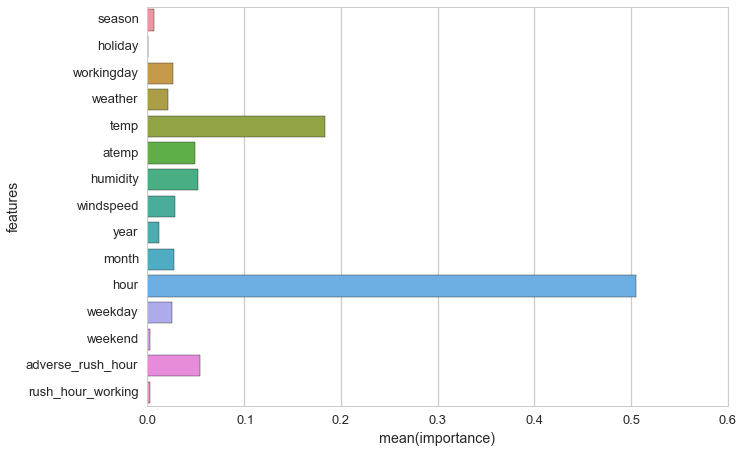

In [105]:
imp = ada.fit(train[x_1], np.log(train['casual'] + 1)).feature_importances_
df_imp = pd.DataFrame({'features':x_1, 'importance': imp})
sns.barplot(y = 'features', x = 'importance', data = df_imp);

#### 3.7 add new features

Below fetures is introduced by this [link](https://www.analyticsvidhya.com/blog/2015/06/solution-kaggle-competition-bike-sharing-demand/). 

In [6]:
train['hour_reg'] = 0
train.loc[train.hour < 7, 'hour_reg'] = 1
train.loc[train.hour == 7, 'hour_reg'] = 2
train.loc[train.hour == 8, 'hour_reg'] = 3
train.loc[(train.hour > 8) & (train.hour < 16), 'hour_reg'] = 4
train.loc[(train.hour == 16) | (train.hour == 17), 'hour_reg'] = 5
train.loc[(train.hour == 18) | (train.hour == 19), 'hour_reg'] = 6
train.loc[train.hour >= 20, 'hour_reg'] = 7

test['hour_reg'] = 0
test.loc[test.hour < 7, 'hour_reg'] = 1
test.loc[test.hour == 7, 'hour_reg'] = 2
test.loc[test.hour == 8, 'hour_reg'] = 3
test.loc[(test.hour > 8) & (test.hour < 16), 'hour_reg'] = 4
test.loc[(test.hour == 16) | (test.hour == 17), 'hour_reg'] = 5
test.loc[(test.hour == 18) | (test.hour == 19), 'hour_reg'] = 6
test.loc[test.hour >= 20, 'hour_reg'] = 7

In [7]:
train['hour_cas'] = 0
train.loc[train.hour <= 7, 'hour_cas'] = 1
train.loc[(train.hour == 8) | (train.hour == 9), 'hour_cas'] = 2
train.loc[(train.hour >= 10) & (train.hour < 20), 'hour_cas'] = 3
train.loc[train.hour >= 20, 'hour_cas'] = 4

test['hour_cas'] = 0
test.loc[test.hour <= 7, 'hour_cas'] = 1
test.loc[(test.hour == 8) | (test.hour == 9), 'hour_cas'] = 2
test.loc[(test.hour >= 10) & (test.hour < 20), 'hour_cas'] = 3
test.loc[test.hour >= 20, 'hour_cas'] = 4

In [8]:
train['temp_reg'] = 0
train.loc[train.temp < 13, 'temp_reg'] = 1
train.loc[(train.temp >= 13) & (train.temp < 23), 'temp_reg'] = 2
train.loc[(train.temp >= 23) & (train.temp < 30), 'temp_reg'] = 3
train.loc[train.temp >= 30, 'temp_reg'] = 4

test['temp_reg'] = 0
test.loc[test.temp < 13, 'temp_reg'] = 1
test.loc[(test.temp >= 13) & (test.temp < 23), 'temp_reg'] = 2
test.loc[(test.temp >= 23) & (test.temp < 30), 'temp_reg'] = 3
test.loc[test.temp >= 30, 'temp_reg'] = 4

In [9]:
train['temp_cas'] = 0
train.loc[train.temp < 15, 'temp_cas'] = 1
train.loc[(train.temp >= 15) & (train.temp < 23), 'temp_cas'] = 2
train.loc[(train.temp >= 23) & (train.temp < 30), 'temp_cas'] = 3
train.loc[train.temp >= 30, 'temp_cas'] = 4

test['temp_cas'] = 0
test.loc[test.temp < 15, 'temp_cas'] = 1
test.loc[(test.temp >= 15) & (test.temp < 23), 'temp_cas'] = 2
test.loc[(test.temp >= 23) & (test.temp < 30), 'temp_cas'] = 3
test.loc[test.temp >= 30, 'temp_cas'] = 4

In [10]:
train['year_part'] = 0
train.loc[(train.year == 2011) & (train.month <= 3), 'year_part'] = 1
train.loc[(train.year == 2011) & (train.month > 3) & (train.month <= 6), 'year_part'] = 2
train.loc[(train.year == 2011) & (train.month > 6) & (train.month <= 9), 'year_part'] = 3
train.loc[(train.year == 2011) & (train.month > 9), 'year_part'] = 4
train.loc[(train.year == 2012) & (train.month <= 3), 'year_part'] = 5
train.loc[(train.year == 2012) & (train.month > 3) & (train.month <= 6), 'year_part'] = 6
train.loc[(train.year == 2012) & (train.month > 6) & (train.month <= 9), 'year_part'] = 7
train.loc[(train.year == 2012) & (train.month > 9), 'year_part'] = 8

test['year_part'] = 0
test.loc[(test.year == 2011) & (test.month <= 3), 'year_part'] = 1
test.loc[(test.year == 2011) & (test.month > 3) & (test.month <= 6), 'year_part'] = 2
test.loc[(test.year == 2011) & (test.month > 6) & (test.month <= 9), 'year_part'] = 3
test.loc[(test.year == 2011) & (test.month > 9), 'year_part'] = 4
test.loc[(test.year == 2012) & (test.month <= 3), 'year_part'] = 5
test.loc[(test.year == 2012) & (test.month > 3) & (test.month <= 6), 'year_part'] = 6
test.loc[(test.year == 2012) & (test.month > 6) & (test.month <= 9), 'year_part'] = 7
test.loc[(test.year == 2012) & (test.month > 9), 'year_part'] = 8

In [11]:
train['day_type'] = 0
train.loc[(train.holiday == 0) & (train.workingday == 0), 'day_type'] = 1
train.loc[(train.holiday == 0) & (train.workingday == 1), 'day_type'] = 2
train.loc[train.holiday == 1, 'day_type'] = 3

test['day_type'] = 0
test.loc[(test.holiday == 0) & (test.workingday == 0), 'day_type'] = 1
test.loc[(test.holiday == 0) & (test.workingday == 1), 'day_type'] = 2
test.loc[test.holiday == 1, 'day_type'] = 3

In [20]:
x_t3_r = ['season', 'holiday', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'year', 'hour',\
        'weekday', 'hour_reg', 'temp_reg', 'year_part', 'day_type', 'rush_hour_working', 'adverse_rush_hour', 'temp'] 

x_t3_c = ['season', 'holiday', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'year', 'hour',\
        'weekday', 'hour_cas', 'temp_cas', 'year_part', 'day_type', 'rush_hour_working', 'adverse_rush_hour', 'temp'] 

In [19]:
# Extra Tree
# predict registered and casual separately
# log
# 0.41573 x_t2
# 0.42089 x_t3
# 0.41344 x_t3_r 100trees p/3
# 0.41340 500trees p/3
# 0.42489 add temp month 500trees p/3
# 0.42561 add temp month 100tree p/3
# 0.42532 add temp month 100tree sqrt
etree2 = ExtraTreesRegressor(n_estimators = 100, random_state = 0, max_features = 'sqrt')
etree_s_pred2 = np.exp(etree2.fit(train[x_t3_c], np.log(train['casual'] + 1)).predict(test[x_t3_c])) +\
                 np.exp(etree2.fit(train[x_t3_r], np.log(train['registered'] + 1)).predict(test[x_t3_r])) - 2
etree_s_df2 = pd.DataFrame({'datetime': test.datetime, 'count':pd.Series(etree_s_pred2)}) 
etree_s_df2.to_csv('python_etree_x_t3.csv', index = False, date_format = "%Y-%m-%d %H:%M:%S")

In [21]:
# random forest
# predict registered and casual separately
# log
# 0.43148 x_t2
# 0.44282 x_t3 top5
# 0.44282 top5+
# 0.40415 x_t3_r 250trees p/3
# 0.40389 500trees sqrt
# add temp month 0.41720
# add month 0.42208
# add temp 0.40146
rf2 = RandomForestRegressor(n_estimators = 500, random_state = 0, max_features = "sqrt") 
rf_pred2 = np.exp(rf2.fit(train[x_t3_c], np.log(train['casual'] + 1)).predict(test[x_t3_c])) +\
                 np.exp(rf2.fit(train[x_t3_r], np.log(train['registered'] + 1)).predict(test[x_t3_r])) - 2
rf_df2 = pd.DataFrame({'datetime': test.datetime, 'count':pd.Series(rf_pred2)}) 
rf_df2.to_csv('python_rf_x_t3.csv', index = False, date_format = "%Y-%m-%d %H:%M:%S")

In [15]:
# try ada 
# x_t3_r 0.43519
ada = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators = 100, random_state = 0)
rf_pred2 = np.exp(ada.fit(train[x_t3_c], np.log(train['casual'] + 1)).predict(test[x_t3_c])) +\
                 np.exp(ada.fit(train[x_t3_r], np.log(train['registered'] + 1)).predict(test[x_t3_r])) - 2
rf_df2 = pd.DataFrame({'datetime': test.datetime, 'count':pd.Series(rf_pred2)}) 
rf_df2.to_csv('python_ada_x_t3.csv', index = False, date_format = "%Y-%m-%d %H:%M:%S")